In [1]:
import torch
import pandas as pd
import numpy as np

from fastai.text.data import TextLMDataBunch, TextClasDataBunch, load_data, DatasetType
from fastai.text import language_model_learner, AWD_LSTM, text_classifier_learner
from fastai.callbacks import SaveModelCallback

from sklearn.model_selection import train_test_split
from os.path import join, isfile
import re

torch.cuda.set_device(1)

Data exploration was done in notebook avito_test_task_part1.

In [2]:
data_path = '/home/egor/DL/AvitoTestTask/data/'
result_path = '/home/egor/DL/AvitoTestTask/results'
models_path = '/home/egor/DL/AvitoTestTask/models_data'

In [3]:
train_df = pd.read_csv(join(data_path, 'train.csv'))
test_df = pd.read_csv(join(data_path, 'test.csv'))
categ_df = pd.read_csv(join(data_path, 'category.csv'))

In [4]:
hierarchy_dict = {
    'Бытовая_электроника': list(range(15)),
    'Для дома и дачи': list(range(15, 30)),
    'Личные вещи': list(range(30, 42)),
    'Хобби и отдых': list(range(42, 54)),
}

In this notebook I will use fastai implementation of ULMFiT to make classifier.

## Test functions

In [5]:
# function to get average accuracy
def get_accuracy(y_pred, y):
    true = np.sum(np.float32(y_pred == y))
    return true / len(y)

# function to get accuracy per each category
# category's ranges are in hierarchy_dict
def get_hierarchy_accuracy(y_pred, y, hierarchy_dict):
    acc_dict = {}
    for categ, range_ in hierarchy_dict.items():
        # find indeces where class is from current category
        indices = np.where(np.isin(y, range_) == True)[0]
        categ_true = np.sum(np.float32(y_pred[indices] == y[indices]))
        acc_dict[categ] = categ_true / len(indices)
    return acc_dict

# Data preparation

Fine-tuning of ULMFiT has two stages: fine-tuning language model on text from task domain and teaching a classifier.

For the first stage I will make csv with texts from train and test df. For the second stage train and test sets will be used separately.

In [5]:
lm_csv = pd.concat([train_df.drop(columns=['category_id']), test_df], axis=0)
lm_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732683 entries, 0 to 243165
Data columns (total 4 columns):
item_id        732683 non-null int64
title          732683 non-null object
description    732683 non-null object
price          732683 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 27.9+ MB


Concatenate title, description and price with special tokens between them (to give model additional information). Price is encoded with # as I suppose that price order matters more than exact number (e.g. 12000 -> price#####).

In [6]:
def prepare_text(title, description, price):
    enc_price = re.sub('\d', '#', str(int(price)))
    proc_text = 'xxtitle {} xxdescr {} xxprice {}'.format(title, description, enc_price)
    return proc_text

In [28]:
lm_csv['text'] = lm_csv.apply(lambda x: prepare_text(x['title'], x['description'], x['price']), axis=1)
lm_csv.to_csv(join(data_path, 'ulmfit_lm.csv'), columns=['text'] ,index=False)
lm_csv.head()

,item_id,title,description,price,text
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,xxtitle Картина xxdescr Гобелен. Размеры 139х8...
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,xxtitle Стулья из прессованной кожи xxdescr Пр...
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,xxtitle Домашняя мини баня xxdescr Мини баня М...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,"xxtitle Эксклюзивная коллекция книг ""Трансаэро..."
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,xxtitle Ноутбук aser xxdescr Продаётся ноутбук...


In [5]:
# load train and test data if there have already been created else create it
train_path = join(data_path, 'ulmfit_train.csv')
test_path = join(data_path, 'ulmfit_test.csv')

if isfile(train_path) and isfile(test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
else:
    train_df['text'] = train_df.apply(lambda x: prepare_text(x['title'], x['description'], x['price']), axis=1)
    test_df['text'] = test_df.apply(lambda x: prepare_text(x['title'], x['description'], x['price']), axis=1)
    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

# ULMFiT language model fine-tuning

In [6]:
# create batcher
data_lm = TextLMDataBunch.from_csv(path=data_path, csv_name='ulmfit_lm.csv', valid_pct=0.1,
                                  text_cols='text')
data_lm.show_batch()

idx,text
0,"игрового компьютера - xxunk любую видеокарту и играй в удовольствие . xxmaj осмотр и покупка товара xxup тц "" xxmaj парк xxmaj xxunk "" , xxmaj xxunk xxup xxunk , 1-й этаж , напротив xxunk , компьютерный салон "" xxmaj xxunk "" xxprice xxrep 5 # xxbos xxtitle xxmaj портьеры в пол xxunk цвета xxdescr xxmaj ткань плотная , верх на широкой кулиске , сборка небольшая . xxmaj размер :"
1,"xxmaj hello xxmaj kitty окрашен в несколько оттенков розового цвета , декорирован изображениями xxmaj китти состоит из двух частей , которые соединяются с помощью специальной липучки работает от управляющего модуля , на котором есть регулируемый динамик и xxunk лампочки коврик для танца xxmaj xxunk xxmaj китти может воспроизвести четыре композиции игрушку можно подсоединить к xxunk , игровой приставке или компьютеру легко складывается , не занимает много места в комнате танцевальный"
2,"xxmaj доминикана , xxmaj индия , xxmaj кипр , xxmaj тунис , xxmaj греция , xxmaj испания , xxmaj крым , xxmaj сочи xxrep 93 | xxmaj при покупке скажите xxup avito и получите xxup скидку 📌 с 2006 xxup года в xxup туризме 📌 xxup только xxup проверенные xxup туроператоры 📌 xxup нет xxup скрытых xxup платежей и xxup сборов 📌 xxup без xxup праздников и xxup выходных 📌"
3,"стиральная машина фронтальная загрузка cтирка до 5 кг класс энергопотребления : a электронное управление xxunk см отжим при 1000 об / мин защита от протечек xxmaj доставка xxmaj также возможен обмен вашей xxunk стиральной машины -на нашу рабочую . xxrep 53 = xxmaj так же в продаже есть недорогие стиральные машины в хорошем состоянии , с xxunk гарантией . xxrep 54 = xxmaj проводим также , ремонт любой сложности ,"
4,\t нет xxmaj наличие xxunk . зам . пилки : \t есть xxmaj регулировка наклона подошвы без инструмента : \t нет xxmaj наличие лазера : \t нет xxmaj наличие плавного пуска : \t нет xxmaj поддержание постоянных оборотов под нагрузкой : \t нет xxmaj возможность подключения к пылесосу : \t нет xxmaj легкий доступ к щеткам : \t нет xxmaj наличие защитного экрана : \t есть xxmaj литая подошва :


In [9]:
data_lm.save(join(data_path, 'data_lm.pkl'))

In [5]:
data_lm = load_data(data_path, 'data_lm.pkl')

Weights of pretrained on Russian language ULMFiT were taken from https://github.com/mamamot/Russian-ULMFit

In [7]:
# create learner
pretrained_fnames = ('/home/egor/DL/rus_ulmfit_weights/lm_5_ep_lr2-3_5_stlr', 
                    '/home/egor/DL/rus_ulmfit_weights/itos')

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained_fnames=pretrained_fnames)

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


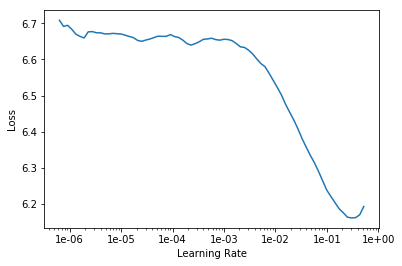

In [37]:
learn.recorder.plot(skip_end=15);

In [38]:
# start fine-tuning
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.313212,3.157330,0.436854,53:28


In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.841331,2.793773,0.489776,59:24
1,2.703325,2.638601,0.513735,58:53
2,2.603848,2.588508,0.521897,58:52


In [42]:
learn.save(join(models_path, 'fine_tuned'))

In [11]:
learn.load(join(models_path, 'fine_tuned'));

In [14]:
# generate some text
TEXT = 'xxtitle Кофе-машина из Авито'
N_WORDS = 40
N_SENTENCES = 2
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

xxtitle Кофе-машина из Авито xxdescr Мы производства baby от лампы . На акция год 19 0 . Мебели и мебели лежит из диски 12000 тем . Поможет удобные карусель 1946 и линзы карту из Кож . Мы склад

xxtitle Кофе-машина из Авито Эллиптический - Днс xxdescr Хром от времени - наличными книгу Во способен . Мы книгу Вам испания Вам лето . Тип : Ручек - Ручек Ручек Тип


In [15]:
learn.save_encoder(join(models_path, 'fine_tuned_enc'))

# ULMFiT classifier training

In [6]:
# create batcher
train_name, test_name = 'train.csv', 'test.csv'
data_clas = TextClasDataBunch.from_csv(path=data_path, csv_name=train_path, valid_pct=0.15, 
                                       test=test_path, vocab=data_lm.train_ds.vocab, 
                                        bs=64, text_cols='text', label_cols='category_id')
data_clas.save(join(data_path, 'data_clas.pkl'))

NameError: name 'train_path' is not defined

In [6]:
data_clas = load_data(data_path, 'data_clas.pkl')
# reduced bs to fit data on my GPU
data_clas.batch_size = 32
data_clas.show_batch()

text,target
"xxbos xxtitle xxmaj манжета люка для стиральной машины xxunk xxdescr б / у манжета люка ( уплотнитель двери ) xxunk - 02 устанавливают в следующие марки стиральных машин xxmaj indesit ( xxmaj индезит ) , xxmaj ariston ( xxmaj аристон ) , xxmaj xxunk ( xxmaj xxunk ) xxmaj состояние хорошие . xxmaj манжета ( резина ) люка для стиральной машины xxmaj indesit , xxmaj ariston xxunk - 02 xxmaj",26
xxbos xxtitle xxmaj роутер ( xxmaj маршрутизатор ) zyxel xxup p-330w xxup ee xxdescr xxmaj интернет - центр zyxel xxup p-330w предназначен для безопасного подключения к xxmaj интернету по выделенной линии xxmaj ethernet через xxunk сети . с его помощью все домашние компьютеры и сетевые устройства могут совместно использовать высокоскоростной выделенный канал . xxmaj основные преимущества : * xxmaj рекомендован ведущими интернет - провайдерами * xxmaj постоянное подключение к xxmaj,14
"xxbos xxtitle "" xxmaj вероятность равна нулю "" - xxunk повести xxdescr "" xxmaj вероятность равна нулю "" - xxunk xxunk . xxunk не будет "" - фантастические повести и xxunk 1991 г . xxmaj ещё книги по 55р : "" в стране xxmaj xxunk "" - xxmaj слово о xxmaj дании - 1990 г . xxmaj давид xxmaj xxunk "" xxmaj до свидания , друг вечный "" , """,43
"xxbos xxtitle xxmaj fujitsu lifebook xxup xxunk ( обмен ) xxdescr xxmaj самый миниатюрный , но в то же время полноценный ноутбук с xxup os xxmaj windows xxup xp , xxmaj fujitsu lifebook xxunk японец ! xxmaj описание xxmaj fujitsu lifebook xxup xxunk : xxmaj модель \t lifebook xxup xxunk xxmaj производитель \t xxmaj fujitsu xxmaj основные характеристики xxmaj fujitsu lifebook xxup xxunk : xxmaj процессор \t xxup xxunk 800",1
"xxbos xxtitle xxmaj шезлонг с дугой , игрушками и вибро , xxunk под xxdescr xxmaj продаю шезлонг , нас выручал очень , даже муж , который xxunk относится к моим детским xxunk разных xxunk , оценил во время пользования ) xxmaj шезлонг в отличном состоянии , все в рабочем состоянии , без пятен и тд . xxmaj важные xxmaj плюсы на мой взгляд : xxunk ( специально с ним xxunk",34


Start training gradually unfreezing layers one per step to prevent catastrophic forgetting the global knowledge of Russian language (here plus global knowledge about Avito advertisments).

In [7]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(join(models_path, 'fine_tuned_enc'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


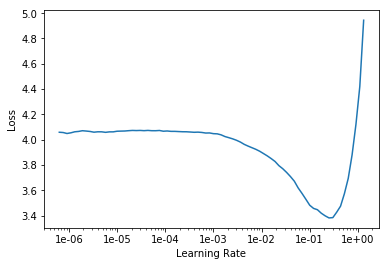

In [9]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.246747,1.726099,0.570423,08:01


In [12]:
learn.save(join(data_path, 'first'))

In [8]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.018458,0.750000,0.800880,10:17


In [9]:
learn.save(join(data_path, 'second'))

In [8]:
learn.load(join(data_path, 'second'));

In [9]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.712611,0.560384,0.845563,21:48


In [10]:
learn.save(join(data_path, 'third'))

In [7]:
learn.load(join(data_path, 'third'));

In [8]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, name=join(models_path, 'fine_tuned_best'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.671696,0.538807,0.849540,31:45
1,0.600233,0.507717,0.859481,31:02
2,0.538444,0.472282,0.868197,31:44
3,0.560615,0.451094,0.871806,32:01
4,0.450817,0.452639,0.874898,30:31
5,0.438490,0.452861,0.876396,31:32


Better model found at epoch 0 with val_loss value: 0.5388070940971375.
Better model found at epoch 1 with val_loss value: 0.5077168345451355.
Better model found at epoch 2 with val_loss value: 0.47228237986564636.
Better model found at epoch 3 with val_loss value: 0.45109379291534424.


In [18]:
learn.load(join(models_path, 'fine_tuned_best'));

In [8]:
learn.load(join(models_path, 'fine_tuned_best'));

In [9]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, name=join(models_path, 'fine_tuned_best_1'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.488952,0.454865,0.874367,28:31
1,0.460834,0.458494,0.875129,28:33
2,0.497688,0.438901,0.877526,27:29
3,0.452463,0.432769,0.878493,28:24
4,0.406739,0.421498,0.880917,30:59
5,0.383145,0.425543,0.883178,30:40
6,0.350866,0.423580,0.883641,31:25
7,0.347736,0.424277,0.884077,27:05


Better model found at epoch 0 with val_loss value: 0.45486512780189514.
Better model found at epoch 2 with val_loss value: 0.4389010965824127.
Better model found at epoch 3 with val_loss value: 0.43276897072792053.
Better model found at epoch 4 with val_loss value: 0.4214983582496643.


In [22]:
learn.save(join(models_path, 'fine_tuned_best_1'))

### Calculate accuracies on validation data

In [23]:
val_preds, val_labels = learn.get_preds(DatasetType.Valid, ordered=True)
val_preds = val_preds.argmax(dim=1).data.cpu().numpy()
val_labels = val_labels.data.cpu().numpy()

In [24]:
# final validation accuracy
get_accuracy(val_preds, val_labels)

0.880917361224601

In [25]:
# final validation accuracy per category
get_hierarchy_accuracy(val_preds, val_labels, hierarchy_dict)

{'Бытовая_электроника': 0.940764783446597,
 'Для дома и дачи': 0.8599819331526649,
 'Личные вещи': 0.8625627673423842,
 'Хобби и отдых': 0.8541037108666747}

### Predict on test data

In [26]:
test_preds, _ = learn.get_preds(DatasetType.Test, ordered=True)

In [27]:
test_preds = test_preds.argmax(dim=1).data.cpu().numpy()

In [28]:
# create df with test predictions and save it
submission_dict = {
    'item_id': test_df['item_id'].to_list(),
    'category_id': test_preds
}

submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv(join(result_path, 'ulmfit_test_prediction.csv'), index=False)
submission_df.head()

,item_id,category_id
0,489517,22
1,489518,0
2,489519,15
3,489520,33
4,489521,13
